In [1]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import time
import matplotlib.patches as mpatches
import psycopg2
from datetime import date, timedelta

In [11]:
with open ('/Users/patriciosanchez/Documents/Python/Connections/dwh.txt', 'r') as file:
    lines=file.readlines()
    dwh_host=lines[0].strip('\n')
    dwh_user=lines[1].strip('\n')
    dwh_port=lines[2].strip('\n')
    dwh_database=lines[3].strip('\n')
    dwh_password=lines[4].strip('\n')
    file.close()
    
con = psycopg2.connect( host=dwh_host,
                        user=dwh_user,
                        port=dwh_port,
                        dbname=dwh_database,
                        password=dwh_password)


# Define timeframe
start_date = date(2021, 7, 22)
end_date = date(2021, 7, 30)
delta = timedelta(days=1)
data = pd.DataFrame()

# Loop all days
while start_date < end_date:
    print (start_date.strftime("%Y-%m-%d"))
    next_date = start_date+delta
    
    qry = '''select     o.id,
           o.creation_time,
           date_trunc('day', o.creation_time) as "day_creation_time",
           o.country_code,
           p.payment_status,
           o.final_status,
           p.forgiven,
           p.bundled_payment_parent_id,
           o.gtv/o.exchange_rate_currency as order_gtv,
           nullif(json_extract_path_text(features, 'ml', 'ml_uch', 'score'),' ')::int as score,
           nullif(json_extract_path_text(features, 'ml', 'ml_uch', 'shadowing', 'ml_uch_v3', 'score'),' ')::int as score_v2,
           json_extract_path_text(features, 'ravelin', 'shadowing','score') as rav_score
            from risk_feature_snapshots rfs
            join checkout_order co on json_extract_path_text(features, 'order', 'checkoutId') = cast(co.checkout_id as text)
            left join orders o on o.id = co.order_id
            left join payments p on p.order_id = o.id
            where 1=1
            and rfs.checkpoint = 'checkout'
            and o.country_code not in ('CR', 'EC', 'PE', 'HN', 'GT')
            and o.ordering_payment_method = 'CASH'
            and o.final_status in ('DeliveredStatus', 'CanceledStatus')
            and score is not null
            and score_v2 is not null
            and o.creation_time >= \'''' + start_date.strftime("%Y-%m-%d") + '\' and o.creation_time < \'' + next_date.strftime("%Y-%m-%d") + '\''

    df = pd.read_sql_query(qry, con)
    data = data.append(df)
    start_date = next_date
    
con.close ()

2021-07-22
2021-07-23
2021-07-24
2021-07-25
2021-07-26
2021-07-27
2021-07-28
2021-07-29


In [3]:
data = data[data['bundled_payment_parent_id'].isna()]

In [4]:
data['rav_score'].replace('', np.nan, inplace=True)
data.dropna(subset=['rav_score'], inplace=True)
data['rav_score'] = data['rav_score'].astype(np.int64)

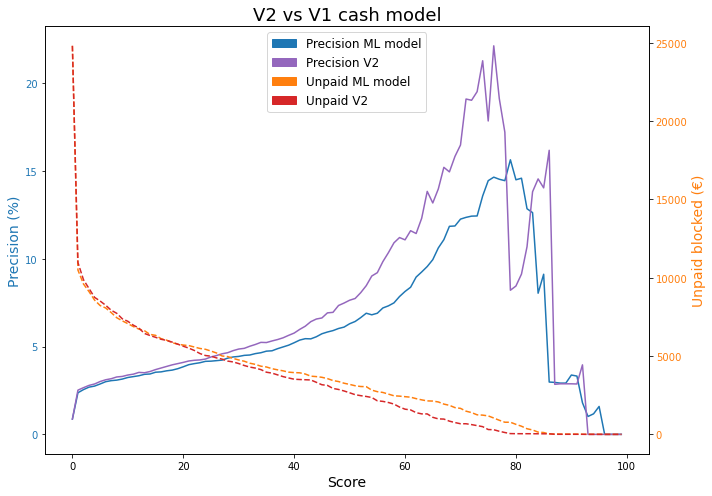

In [25]:
total_unpaid = data[(data['payment_status']=='NOT_PAID')]['order_gtv'].sum()

def statistics(df, df_unpaid):
    unpaid = df[(df['payment_status']=='NOT_PAID')]['order_gtv'].sum()
    paid = df[(df['payment_status']=='PAID')]['order_gtv'].sum()
    total = unpaid + paid
    precision = 100*unpaid/total
    recall = 100*unpaid/df_unpaid
    
    return(round(unpaid,0), round(precision,2), round(recall,2))



def get_plots(low_score, df):

    rav_unpaid_plot, rav_prec_plot = [], []
    ml_unpaid_plot, ml_prec_plot = [], []

    for s in list(range(low_score, 100)):
        rav = df[df['score_v2']>=s]
        ml = df[df['score']>=s]

        rav_unpaid, rav_prec, rav_rec = statistics(rav, total_unpaid)
        rav_unpaid_plot.append(rav_unpaid)
        rav_prec_plot.append(rav_prec)

        ml_unpaid, ml_prec, ml_rec = statistics(ml, total_unpaid)
        ml_unpaid_plot.append(ml_unpaid)
        ml_prec_plot.append(ml_prec)


    # Plot
    fig, ax1 = plt.subplots(figsize=(10,7))
    
    ax1.set_title("V2 vs V1 cash model", fontsize=18)
    
    ax1.set_xlabel('Score', fontsize=14)
    ax1.set_ylabel('Precision (%)', color='tab:blue', fontsize=14)
    ax1.plot(list(range(low_score, 100)), ml_prec_plot, color='tab:blue', label='ML model Precision')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Unpaid blocked (€)', color='tab:orange', fontsize=14) 
    ax2.plot(list(range(low_score, 100)), ml_unpaid_plot, color='tab:orange', label='ML model Unpaid blocked', linestyle='dashed')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    ax1.plot(list(range(low_score, 100)), rav_prec_plot, color='tab:purple', label='V2 Precision')
    ax2.plot(list(range(low_score, 100)), rav_unpaid_plot, color='tab:red', label='Ravelin Unpaid blocked', linestyle='dashed')

    blue = mpatches.Patch(color='tab:blue', label='Precision ML model')
    orange = mpatches.Patch(color='tab:orange', label='Unpaid ML model')
    purple = mpatches.Patch(color='tab:purple', label='Precision V2')
    red = mpatches.Patch(color='tab:red', label='Unpaid V2')
    plt.legend(handles=[blue, purple, orange,red], loc='upper center', fontsize=12)
    fig.tight_layout()
    plt.show()
    
    return rav_unpaid_plot, rav_prec_plot, ml_unpaid_plot, ml_prec_plot

a,b,c,d = get_plots(0, data)

In [27]:
print("Precision 3.85%:")
print(statistics(data[data['score']>=20], total_unpaid))
print(statistics(data[data['score_v2']>=17], total_unpaid))
print("\nPrecision 5.2%:")
print(statistics(data[data['score']>=40], total_unpaid))
print(statistics(data[data['score_v2']>=36], total_unpaid))
print("\nPrecision 8.2%:")
print(statistics(data[data['score']>=60], total_unpaid))
print(statistics(data[data['score_v2']>=53], total_unpaid))
print("\nPrecision 12.4%:")
print(statistics(data[data['score']>=83], total_unpaid))
print(statistics(data[data['score_v2']>=63], total_unpaid))

Precision 3.85%:
(5701.0, 3.85, 22.99)
(6001.0, 3.87, 24.2)

Precision 5.2%:
(3944.0, 5.22, 15.9)
(3910.0, 5.32, 15.77)

Precision 8.2%:
(2406.0, 8.14, 9.7)
(2420.0, 8.47, 9.76)

Precision 12.4%:
(281.0, 12.63, 1.13)
(1308.0, 12.31, 5.27)


In [14]:
print(statistics(data[data['score']>=95], total_unpaid))
print(statistics(data[data['score_v2']>=95], total_unpaid))

(4.61659572183989, 1.5851314769069276, 0.01861341574915876)
(0.0, 0.0, 0.0)
